# Imports

In [1]:
# Basics
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
import csv
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from functools import reduce

# MongoDB
from pymongo import MongoClient

# natural language processing
import nltk
from textblob import TextBlob
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.corpus import stopwords
from ingreedypy import Ingreedy

# sklearn
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# gensim
from gensim import corpora, models, similarities, matutils

# Other
import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
# text data
df_text = pd.read_pickle('df_01.pkl')

In [3]:
# cbow data
df_cbow = pd.read_pickle('df_02.pkl')

In [4]:
# word2vec vectors
df_vec = pd.read_pickle('df_03.pkl')

In [5]:
# tags
df_tags = pd.read_pickle('df_04.pkl')

In [6]:
recipe_titles = df_tags.index

In [7]:
df_tags['recipe_name'] = recipe_titles

In [8]:
df_tags.reset_index(drop=True, inplace=True)

In [9]:
df_cbow['tags_kmeans'] = df_tags.kmeans_rec

In [12]:
df_cbow.iloc[99].ingredients

[['large', 'ripe', 'tomatoes', 'about', 'pounds', 'ripe_tomatoes'],
 ['large', 'cucumber', 'peeled', 'seeded', 'diced', 'about', 'cups'],
 ['green', 'bell', 'pepper', 'chopped', 'bell_pepper'],
 ['red', 'onion', 'chopped', 'onion_chopped'],
 ['cup', 'tomato', 'juice', 'tomato_juice'],
 ['cup', 'bottled', 'clam', 'juice', 'clam_juice'],
 ['tablespoons', 'red', 'wine', 'vinegar', 'wine_vinegar'],
 ['tablespoons', 'olive', 'oil', 'olive_oil'],
 ['tablespoons', 'fresh', 'lemon', 'juice', 'lemon_juice'],
 ['tablespoons',
  'chopped',
  'fresh',
  'basil',
  'tablespoons_chopped',
  'fresh_basil'],
 ['tablespoons', 'chopped', 'fresh', 'parsley', 'tablespoons_chopped'],
 ['teaspoons', 'old', 'bay', 'seasoning'],
 ['ounces', 'cooked', 'shrimp', 'cut', 'into', 'inch', 'pieces']]

In [13]:
cbow = []
for i in range(len(df_cbow)):
    cbow_temp = []
    row = df_cbow.iloc[i]
    cbow_temp.extend(row.title)
    for ing in row.ingredients:
        cbow_temp.extend(ing)
    for dir_ in row.directions:
        cbow_temp.extend(dir_)
    cbow.append(cbow_temp)

In [14]:
df_cbow['cbow'] = cbow

In [15]:
df_cbow.head()

,title,ingredients,directions,categories,desc,tags_kmeans,cbow
0,"[lentil, apple, turkey, wrap]","[[cups, low, sodium, vegetable, or, chicken, s...","[[place, stock, lentils, celery, carrot, thyme...","[sandwich, bean, fruit, tomato, turkey, vegeta...",[],Jewish,"[lentil, apple, turkey, wrap, cups, low, sodiu..."
1,"[boudin, blanc, terrine, red, onion, confit, b...","[[cups, whipping, cream, whipping_cream], [med...","[[combine, first, ingredients, heavy, medium, ...","[onion, pork, bake, port, winter, chill]","[uses, ingredients, found, boudin, blanc, clas...",West European,"[boudin, blanc, terrine, red, onion, confit, b..."
2,"[potato, fennel, soup, hodge, fennel_soup]","[[fennel, bulb, sometimes, called, anise, stal...","[[large, heavy, saucepan, cook, diced, fennel,...","[dairy, potato, vegetable, fennel, gourmet]",[],West European,"[potato, fennel, soup, hodge, fennel_soup, fen..."
3,"[mahi, mahi, tomato, olive, sauce, mahi_mahi]","[[tablespoons, extra, virgin, olive, oil, oliv...","[[heat, oil, heavy, large, skillet, medium, hi...","[fish, olive, tomato, sauté, dinner, healthy, ...","[style, tomato, sauce, tons, mediterranean, fl...",Middle Eastern,"[mahi, mahi, tomato, olive, sauce, mahi_mahi, ..."
4,"[spinach, noodle, casserole, noodle_casserole]","[[ounce, package, frozen, spinach, soufflé, th...","[[preheat, oven, lightly, grease, inch, glass,...","[cheese, dairy, pasta, vegetable, side, bake, ...",[],American,"[spinach, noodle, casserole, noodle_casserole,..."


# Word Lists

In [83]:
measurements = ['cup','cups','C','c','gram','grams','g','kilogram','kilograms','kg','liter','liters','L','l',
               'pound','pounds','lb','milliliter','milliliters','ml','mL','ounce','ounces','oz','pint','pints','pt',
               'teaspoon','teaspoons','t','tsp','tablespoon','tablespoons','T','TB','Tbl','Tbsp','tbsp','quart','quarts','qt',
               'dash','pinch','piece','pieces','slice','slices','sheet','sheets','log','stick','sticks']

# Word2Vec Model

In [16]:
import gensim
google_vec_file = '/Users/carliebadder/Downloads/GoogleNews-vectors-negative300.bin'
model = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

In [17]:
model_wv = model.wv
del model

# Cuisine Dictionaries

In [18]:
cuisine_tags = ['African','American','Asian','Dessert','East European',
                'Jewish','Latin','Middle Eastern','West European']

In [108]:
cuisine_dictionaries = {}
for tag in cuisine_tags:
    temp_list = list(df_cbow[df_cbow.tags_kmeans == tag].cbow.values)
    temp_list_flattened = [val for sublist in temp_list for val in sublist]
    temp_list_counter = Counter(temp_list_flattened)        
    cuisine_dictionaries[tag] = temp_list_counter

In [109]:
# total number of words in each cuisine
for c_tag in cuisine_tags:
    print(c_tag,len(cuisine_dictionaries[c_tag]))

African 3890
American 8211
Asian 6952
Dessert 8731
East European 3968
Jewish 5481
Latin 6625
Middle Eastern 6263
West European 8282


In [110]:
skip_words = ['tablespoonfuls','careful','glasses','glass','meat_thermometer','prevent','remainder',
             'subsides','kept','turns','ingredient','fold','el','la','ras','begins','tbsp',
             'minutes','heat','oil','salt','pepper','medium','chopped','bowl','cut','transfer',
             'ingredients','inch','stir','cover','pan','skillet','water','season']

In [111]:
# remove measurement terms from each cuisine's dictionary
for c_tag in cuisine_tags:
    temp_key_list = [word for word in cuisine_dictionaries[c_tag].keys() if word not in measurements]
    cuisine_dictionaries[c_tag] = {k:cuisine_dictionaries[c_tag][k] for k in temp_key_list}
    

In [112]:
# remove measurement terms from each cuisine's dictionary
for c_tag in cuisine_tags:
    temp_key_list = [word for word in cuisine_dictionaries[c_tag].keys() if word not in skip_words]
    cuisine_dictionaries[c_tag] = {k:cuisine_dictionaries[c_tag][k] for k in temp_key_list}
    

In [113]:
skip_pos = ['VBG','CC','JJ','RB','VB','VBN','IN','VBD','JJS','DT','MD','CD','JJR','RBR']

In [114]:
# remove non-nouns from each cuisine's dictionary too
for c_tag in cuisine_tags:
    temp_key_list = [w for w in cuisine_dictionaries[c_tag] if pos_tag(word_tokenize(w))[0][1] not in skip_pos]
    cuisine_dictionaries[c_tag] = {k:cuisine_dictionaries[c_tag][k] for k in temp_key_list}
  

In [120]:
# word rankings - probability of each word
cuisine_word_prob = {}
for c_tag in cuisine_tags:
    temp_total = reduce((lambda x,y: x+y),cuisine_dictionaries[c_tag].values())
    temp_probabilities = [(num/temp_total) for num in list(cuisine_dictionaries[c_tag].values())]
    cuisine_word_prob[c_tag] = dict(list(zip(cuisine_dictionaries[c_tag].keys(),temp_probabilities)))

In [123]:
# assign cuisine to each word to plot
# first create whole word list
word_corpus = []
for c_tag in cuisine_tags:
    # all the words from one cuisine
    temp_words = list(cuisine_dictionaries[c_tag].keys())
    # add them to the word-corpus
    word_corpus.extend(temp_words)


In [205]:
# remove duplicate words
word_corpus = list(set(word_corpus))

In [206]:
# assign the cuisine with the highest probability to each word
tag_corpus = {}
for wc in word_corpus:
    temp_rank = []
    for c_tag in cuisine_tags:
        try:
            temp_rank.append((cuisine_word_prob[c_tag][wc], c_tag))
        except:
            pass
    tag_corpus[wc] = sorted(temp_rank, key=(lambda x: x[0]), reverse=True)

In [207]:
tag_corpus['m eat']

[(0.003797587257283182, 'American'),
 (0.0022341101477792126, 'African'),
 (0.0022017417772892535, 'West European'),
 (0.0019558956282508706, 'Latin'),
 (0.0017470240644001027, 'Asian'),
 (0.0017453008921702587, 'Jewish'),
 (0.0015203648875730174, 'East European'),
 (0.0010662807745768197, 'Middle Eastern'),
 (4.5531811559009226e-05, 'Dessert')]

## Unique Words and PCA

In [208]:
# build dataframe for word_corpus and most probable cuisine
df_word_corpus_list = []
for wc in word_corpus:
    temp_word = wc
    temp_tag = tag_corpus[wc][0][1]
    temp_vec = model_wv[wc]
    df_word_corpus_list.append([temp_word, temp_tag, temp_vec])

In [209]:
df_word_corpus = pd.DataFrame(df_word_corpus_list, columns=['word','tag','vec'])

In [210]:
df_word_corpus.head()

,word,tag,vec
0,restore,Latin,"[-0.017334, 0.310547, -0.121582, -0.0517578, -..."
1,shrimp_cocktail,Latin,"[-0.316406, -0.0306396, 0.0561523, 0.408203, 0..."
2,froyo,Dessert,"[0.0123901, -0.168945, -0.146484, 0.388672, -0..."
3,roasted_chile,Latin,"[-0.0272217, -0.0698242, 0.0161133, 0.036377, ..."
4,bouchon,West European,"[-0.0761719, -0.0214844, 0.0991211, 0.181641, ..."


In [211]:
df_word_corpus.to_pickle('df_word_corpus.pkl')

In [212]:
# PCA
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

vec_vstack = np.vstack(df_word_corpus.vec)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(vec_vstack)

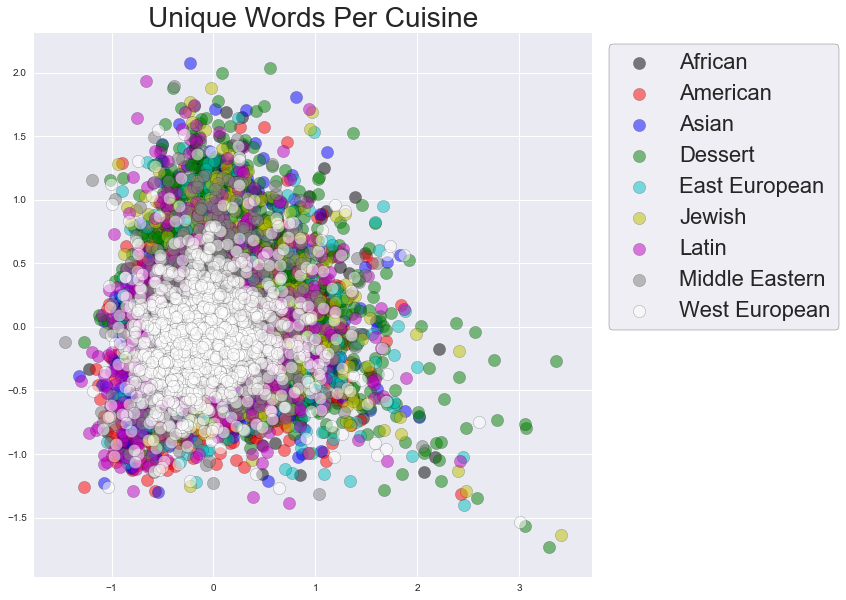

In [213]:
plt.figure(figsize=(10,10))
pcax = 1
pcay = 2
alpha = .5
s = 150
ec = 'k'
plt.scatter(pca_result[df_word_corpus['tag']=='African',pcax], 
            pca_result[df_word_corpus['tag']=='African',pcay],
           alpha=alpha, c = 'k', s=s, edgecolor=ec)
plt.scatter(pca_result[df_word_corpus['tag']=='American',pcax], 
            pca_result[df_word_corpus['tag']=='American',pcay],
           alpha=alpha, c = 'r', s=s, edgecolor=ec)
plt.scatter(pca_result[df_word_corpus['tag']=='Asian',pcax], 
            pca_result[df_word_corpus['tag']=='Asian',pcay],
           alpha=alpha, c = 'b', s=s, edgecolor=ec)
plt.scatter(pca_result[df_word_corpus['tag']=='Dessert',pcax], 
            pca_result[df_word_corpus['tag']=='Dessert',pcay],
           alpha=alpha, c = 'g', s=s, edgecolor=ec)
plt.scatter(pca_result[df_word_corpus['tag']=='East European',pcax], 
            pca_result[df_word_corpus['tag']=='East European',pcay],
           alpha=alpha, c = 'c', s=s, edgecolor=ec)
plt.scatter(pca_result[df_word_corpus['tag']=='Jewish',pcax], 
            pca_result[df_word_corpus['tag']=='Jewish',pcay],
           alpha=alpha, c = 'y', s=s, edgecolor=ec)
plt.scatter(pca_result[df_word_corpus['tag']=='Latin',pcax], 
            pca_result[df_word_corpus['tag']=='Latin',pcay],
           alpha=alpha, c = 'm', s=s, edgecolor=ec)
plt.scatter(pca_result[df_word_corpus['tag']=='Middle Eastern',pcax], 
            pca_result[df_word_corpus['tag']=='Middle Eastern',pcay],
           alpha=alpha, c = 'grey', s=s, edgecolor=ec)
plt.scatter(pca_result[df_word_corpus['tag']=='West European',pcax], 
            pca_result[df_word_corpus['tag']=='West European',pcay],
           alpha=alpha, c = 'w', s=s, edgecolor=ec)

plt.legend(cuisine_tags,fontsize=22,frameon=True,edgecolor='k',bbox_to_anchor=(1.01, 1.0))
plt.title('Unique Words Per Cuisine',fontsize=28)

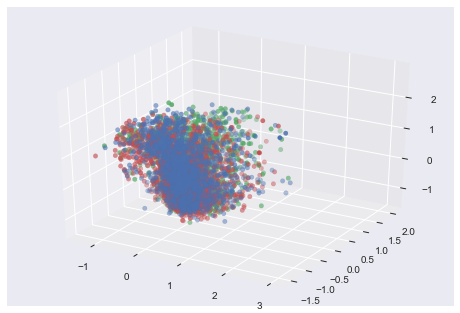

In [214]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pcax=1
pcay=2
pcaz=0

xs = pca_result[df_word_corpus['tag']=='West European',pcax]
ys = pca_result[df_word_corpus['tag']=='West European',pcay]
zs = pca_result[df_word_corpus['tag']=='West European',pcaz]

xs1 = pca_result[df_word_corpus['tag']=='Asian',pcax]
ys1 = pca_result[df_word_corpus['tag']=='Asian',pcay]
zs1 = pca_result[df_word_corpus['tag']=='Asian',pcaz]

xs2 = pca_result[df_word_corpus['tag']=='American',pcax]
ys2 = pca_result[df_word_corpus['tag']=='American',pcay]
zs2 = pca_result[df_word_corpus['tag']=='American',pcaz]

ax.scatter(xs, ys, zs, zdir='z', s=20, c=None, depthshade=True)
ax.scatter(xs1, ys1, zs1, zdir='z', s=20, c=None, depthshade=True)
ax.scatter(xs2, ys2, zs2, zdir='z', s=20, c=None, depthshade=True)

# Meats

In [624]:
main_meat = ['Beef','Pork','Seafood','Poultry','Lamb']

main_meat_list = {'Poultry': ['Chicken','turkey','Duck','Poultry','Poultry_Sausage','Pollo',
                             'Coq'],
       'Beef': ['Beef','Ground_Beef','Steak','Burger','Beef Rib','Brisket','Hamburger',
             'Beef_Shank','Beef_Tenderloin','Bulgogi','Cheeseburger','Mignon','Carpaccio',
               'Veal','Bratwurst','Asada'],
       'Pork': ['Pork','Pork_Rib','Pork_Chop','Pork_Tenderloin','Bacon','Ham','Carnitas',
               'Pig','Chorizo','Coppa','Pepperoni','Soppressata','Speck','Prosciutto'],
       'Lamb': ['Lamb','Ground_Lamb','Lamb_Chop','Lamb_Shank','Rack_Lamb','Moussaka'],
       'Seafood': ['Seafood','Fish','Shellfish','Salmon','Shrimp','Scallop',
             'Halibut','Oyster','Sardine','Swordfish','Tilapia','Trout',
             'Tuna','Sushi','Cioppino','Scampi','Seafoods','Oysters','Trouts','Scallops',
                  'Moules','Anchovy','Anchovies','Seabass','Cod','Catfish','Eel',
                  'Flounder','Grouper','Halibut','Kingfish','Mahi','Mahi_Mahi',
                  'Sardine','Sardines','Caviar','Crab','Crabs','Crayfish','Prawn',
                  'Lobster','Prawns','Mussel','Mussels','Octopus','Squid','Calamari',
                  'Escargot','Roe','Clam','Clams','Chowder','Bisque','Paella']}

In [625]:
all_meats = []
all_meats_main = []
for m in main_meat:
    temp_m = main_meat_list[m]
    temp_m = [mm.lower() for mm in temp_m if mm.lower() in model_wv]
    temp_m = [mm for mm in temp_m if mm in word_corpus]
    all_meats.extend(temp_m)
    all_meats_main.extend([m]*len(temp_m))

In [626]:
# for each cuisine calculate the probability of a meat occuring relative to all the other meats
meat_probs = {}
for c_tag in cuisine_tags:
    temp_meat_dict = {m:cuisine_dictionaries[c_tag][m] for m in all_meats if m in cuisine_dictionaries[c_tag].keys()}
    temp_total_meats = sum(temp_meat_dict.values())
    temp_meat_dict = {m:(temp_meat_dict[m]/temp_total_meats) for m in temp_meat_dict.keys()}
    meat_probs[c_tag] = temp_meat_dict

In [627]:
meat_probs.keys()

dict_keys(['African', 'American', 'Asian', 'Dessert', 'East European', 'Jewish', 'Latin', 'Middle Eastern', 'West European'])

In [628]:
df_meat_probs = pd.DataFrame.from_dict(meat_probs, orient='columns')
df_meat_probs.head()

,African,American,Asian,Dessert,East European,Jewish,Latin,Middle Eastern,West European
anchovies,0.002215,0.001362,0.000532,NaN,0.001403,0.005872,0.003146,0.022423,0.006589
anchovy,0.007752,0.001923,0.001330,NaN,0.001403,0.007046,0.004522,0.034365,0.011296
asada,NaN,NaN,NaN,NaN,NaN,NaN,0.000393,NaN,NaN
bacon,0.016611,0.087747,0.009047,0.269091,0.105189,0.046389,0.023791,0.022179,0.087113
beef,0.033223,0.065550,0.063332,0.032727,0.079944,0.044627,0.058199,0.017548,0.055109


## Meat probs relative to all cuisine words

In [379]:
# df_meats: seasoning, each cuisine's probability
meats_list = []
for m in all_meats:
    temp_tag_list = tag_corpus[m]
    temp_tag_list = sorted(temp_tag_list, key=(lambda x: x[1]))
#     temp_tag_list = [t[0] for t in temp_tag_list]
    temp_row = [m] + temp_tag_list
    meats_list.append(temp_row)

In [380]:
df_meats_dict = {row[0]:{x[1]:x[0] for x in row[1:]} for row in meats_list}

In [381]:
df_meats_probs = pd.DataFrame.from_dict(df_meats_dict, orient='index')
df_meats_probs.head()

,African,American,Asian,Dessert,East European,Jewish,Latin,Middle Eastern,West European
anchovies,0.000082,0.000076,0.000023,NaN,0.000027,0.000115,0.000115,0.000584,0.000260
anchovy,0.000287,0.000107,0.000057,NaN,0.000027,0.000138,0.000165,0.000895,0.000446
asada,NaN,NaN,NaN,NaN,NaN,NaN,0.000014,NaN,NaN
bacon,0.000615,0.004898,0.000388,0.00016,0.002000,0.000907,0.000867,0.000578,0.003443
beef,0.001230,0.003659,0.002718,0.00002,0.001520,0.000873,0.002121,0.000457,0.002178


## Meat Max Probs relative to all cuisine words

In [218]:
# build dataframe for all_meats and most probable cuisine
meat_tag_list = []
for i,m in enumerate(all_meats):
    temp_main_meat = all_meats_main[i]
    temp_word = m
    temp_tag = tag_corpus[m][0][1]
    temp_vec = model_wv[m]
    meat_tag_list.append([temp_word, temp_main_meat, temp_tag, temp_vec])

In [219]:
df_meats = pd.DataFrame(meat_tag_list,columns=['meat','meat_type','tag','vec'])
df_meats.head()

,meat,meat_type,tag,vec
0,beef,Beef,American,"[-0.265625, 0.242188, 0.177734, 0.261719, 0.06..."
1,steak,Beef,Latin,"[-0.296875, 0.0864258, 0.0566406, 0.390625, -0..."
2,burger,Beef,American,"[-0.267578, 0.0522461, 0.00915527, 0.621094, -..."
3,brisket,Beef,Jewish,"[-0.114258, -0.140625, 0.183594, 0.300781, 0.2..."
4,hamburger,Beef,American,"[-0.157227, 0.00257874, 0.141602, 0.605469, -0..."


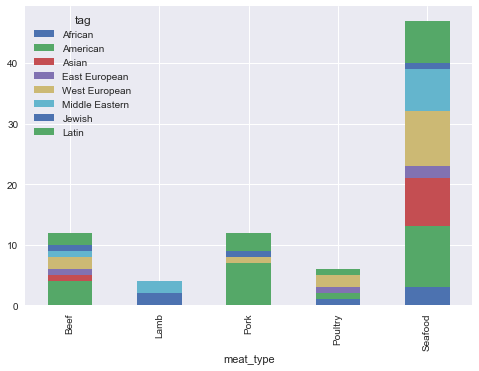

In [220]:
# Stacked Bar Graph of Meat Distribution
df_test = df_meats.groupby(['meat_type','tag'])['tag'].count().unstack('tag').fillna(0)
df_test[['African','American','Asian','East European','West European','Middle Eastern','Jewish','Latin']].plot(kind='bar', stacked=True)


### PCA Meat Probabilities

In [176]:
# PCA
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

meat_vstack = np.vstack(df_meats.vec)
pca_meat = PCA(n_components=3)
pca_meat_result = pca_meat.fit_transform(meat_vstack)

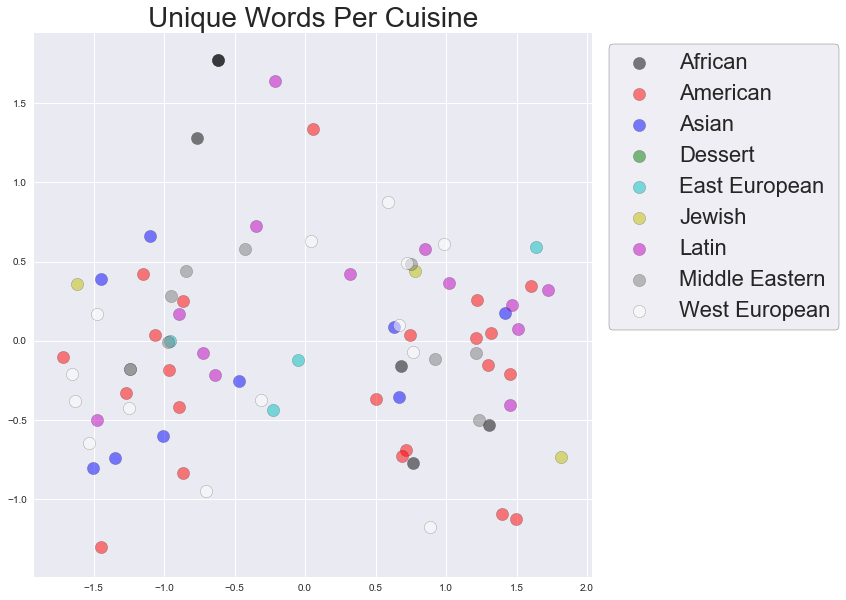

In [179]:
plt.figure(figsize=(10,10))
pcax = 0
pcay = 2
alpha = .5
s = 150
ec = 'k'
plt.scatter(pca_meat_result[df_meats['tag']=='African',pcax], 
            pca_meat_result[df_meats['tag']=='African',pcay],
           alpha=alpha, c = 'k', s=s, edgecolor=ec)
plt.scatter(pca_meat_result[df_meats['tag']=='American',pcax], 
            pca_meat_result[df_meats['tag']=='American',pcay],
           alpha=alpha, c = 'r', s=s, edgecolor=ec)
plt.scatter(pca_meat_result[df_meats['tag']=='Asian',pcax], 
            pca_meat_result[df_meats['tag']=='Asian',pcay],
           alpha=alpha, c = 'b', s=s, edgecolor=ec)
plt.scatter(pca_meat_result[df_meats['tag']=='Dessert',pcax], 
            pca_meat_result[df_meats['tag']=='Dessert',pcay],
           alpha=alpha, c = 'g', s=s, edgecolor=ec)
plt.scatter(pca_meat_result[df_meats['tag']=='East European',pcax], 
            pca_meat_result[df_meats['tag']=='East European',pcay],
           alpha=alpha, c = 'c', s=s, edgecolor=ec)
plt.scatter(pca_meat_result[df_meats['tag']=='Jewish',pcax], 
            pca_meat_result[df_meats['tag']=='Jewish',pcay],
           alpha=alpha, c = 'y', s=s, edgecolor=ec)
plt.scatter(pca_meat_result[df_meats['tag']=='Latin',pcax], 
            pca_meat_result[df_meats['tag']=='Latin',pcay],
           alpha=alpha, c = 'm', s=s, edgecolor=ec)
plt.scatter(pca_meat_result[df_meats['tag']=='Middle Eastern',pcax], 
            pca_meat_result[df_meats['tag']=='Middle Eastern',pcay],
           alpha=alpha, c = 'grey', s=s, edgecolor=ec)
plt.scatter(pca_meat_result[df_meats['tag']=='West European',pcax], 
            pca_meat_result[df_meats['tag']=='West European',pcay],
           alpha=alpha, c = 'w', s=s, edgecolor=ec)

plt.legend(cuisine_tags,fontsize=22,frameon=True,edgecolor='k',bbox_to_anchor=(1.01, 1.0))
plt.title('Unique Words Per Cuisine',fontsize=28)

## Meat Percentages relative to all cuisine words

In [73]:
cuisine_meats = {}
for c_tag in cuisine_tags:
    temp_meat_dict = defaultdict(int)
    # for each main meat in the list of main meats
    for meat_type in main_meat:
        # check through the list of meats in each main meat group
        for meat in main_meat_list[meat_type]:
            # if the specific meat appears in the current cuisine's dictionary
            if meat in cuisine_dictionaries[c_tag]:
                # add the number of occurences to the temporary meat dictionary
                # in the key of the main meat group
                temp_meat_dict[meat_type] += cuisine_dictionaries[c_tag][meat]
       
            if meat.lower() in cuisine_dictionaries[c_tag]:
                # add the number of occurences to the temporary meat dictionary
                # in the key of the main meat group
                temp_meat_dict[meat_type] += cuisine_dictionaries[c_tag][meat.lower()]
   
    cuisine_meats[c_tag] = temp_meat_dict
        

{'African': defaultdict(int,
             {'Beef': 113,
              'Lamb': 575,
              'Pork': 76,
              'Poultry': 989,
              'Seafood': 217}),
 'American': defaultdict(int,
             {'Beef': 1531,
              'Lamb': 162,
              'Pork': 3084,
              'Poultry': 6773,
              'Seafood': 3104}),
 'Asian': defaultdict(int,
             {'Beef': 753,
              'Lamb': 184,
              'Pork': 825,
              'Poultry': 2356,
              'Seafood': 3580}),
 'Dessert': defaultdict(int,
             {'Beef': 17,
              'Lamb': 5,
              'Pork': 149,
              'Poultry': 55,
              'Seafood': 40}),
 'East European': defaultdict(int,
             {'Beef': 95,
              'Lamb': 5,
              'Pork': 204,
              'Poultry': 252,
              'Seafood': 280}),
 'Jewish': defaultdict(int,
             {'Beef': 358,
              'Lamb': 175,
              'Pork': 223,
              'Poultry': 991,

# Spices and Herbs

In [636]:
seasonings = ['anise','basil','caraway','cilantro','coriander','chamomile',
              'dill','fennel_seeds','lavender','lemon_grass','marjoram','oregano',
              'parsley','rosemary','sage','thyme','paprika','cayenne','ginger',
              'cumin','turmeric','mint','pepper','salt','lemongrass',
              'cinnamon','allspice','chili_powder','cloves','peppercorns','asafoetida',
              'cardamom','celery_salt','fenugreek','garlic','mace','mustard_seeds',
              'mustard','nutmeg','saffron','tamarind','vanilla','wasabi','bay_leaf',
              'chives','lavender','tarragon','miso','ancho_chile','anaheim',
              'chipotle','habanero','jalapeno','jalapeño','pasilla','pepper_flakes',
              'serrano','adobo','chai','citrus','harissa','walnut','walnuts','peanuts','peanut',
              'za\'atar','chia','nutritional_yeast','sumac','shiso','almond','almonds',
              'curry_powder','garam_masala','kosher_salt','sesame_seeds','vanilla_extract',
             'cajun_seasoning','jerk_seasoning','mole','mulling','pumpkin_pie','mesquite',
             'tandoori','taco_seasoning','sriracha','allspice_berries','arrowroot','chipotle_chile',
             'cumin_seeds','curry_leaf','dill_weed','horseradish','pickling_spice','vanilla_bean',
             'lemon_juice','orange_juice','cashew','cashews','sesame','sesame_seeds',
             'lemon_peel','orange_peel','lemon_zest','orange_zest']

In [637]:
seasonings = [s for s in seasonings if s in word_corpus]
seasonings = sorted(seasonings)

In [638]:
# for each cuisine calculate the probability of a seasoning occuring relative to all the other seasoning
season_probs = {}
for c_tag in cuisine_tags:
    temp_seas_dict = {m:cuisine_dictionaries[c_tag][m] for m in seasonings if m in cuisine_dictionaries[c_tag].keys()}
    temp_total_seas = sum(temp_seas_dict.values())
    temp_seas_dict = {m:(temp_seas_dict[m]/temp_total_seas) for m in temp_seas_dict.keys()}
    season_probs[c_tag] = temp_seas_dict

In [639]:
df_seas_probs = pd.DataFrame.from_dict(season_probs, orient='columns')
df_seas_probs.head()

,African,American,Asian,Dessert,East European,Jewish,Latin,Middle Eastern,West European
adobo,NaN,0.004071,0.000709,NaN,NaN,NaN,0.011683,0.000553,0.000188
allspice,0.008240,0.007810,0.002979,0.010585,0.010945,0.007006,0.006469,0.003081,0.005500
allspice_berries,0.000175,0.000249,0.000426,0.000376,0.001152,0.000568,0.000869,NaN,0.000875
almond,0.001578,0.000083,0.000993,0.038738,0.002304,0.003787,0.000966,0.001422,0.001188
almonds,0.025070,0.004071,0.003760,0.049592,0.006336,0.020261,0.009462,0.010270,0.004750


In [1]:
df_seas_probs['basil']

NameError: name 'df_seas_probs' is not defined

## Seasonings probs relative to all cuisine words

In [363]:
# df_seasonings: seasoning, each cuisine's probability
seasonings_list = []
for s in seasonings:
    temp_tag_list = tag_corpus[s]
    temp_tag_list = sorted(temp_tag_list, key=(lambda x: x[1]))
#     temp_tag_list = [t[0] for t in temp_tag_list]
    temp_row = [s] + temp_tag_list
    seasonings_list.append(temp_row)

In [369]:
df_seasonings_dict = {row[0]:{x[1]:x[0] for x in row[1:]} for row in seasonings_list}

In [377]:
df_seasonings_probs = pd.DataFrame.from_dict(df_seasonings_dict, orient='index')
df_seasonings_probs.head()

,American,Asian,Latin,Middle Eastern,West European,African,Dessert,East European,Jewish
adobo,0.000219,0.000057,0.000867,0.000044,0.000010,NaN,NaN,NaN,NaN
allspice,0.000420,0.000240,0.000480,0.000248,0.000298,0.000963,0.000427,0.000507,0.000425
allspice_berries,0.000013,0.000034,0.000064,NaN,0.000047,0.000020,0.000015,0.000053,0.000034
anaheim,0.000018,0.000017,0.000150,0.000013,NaN,NaN,NaN,NaN,0.000011
ancho_chile,0.000031,0.000006,0.000294,0.000019,0.000003,NaN,0.000009,NaN,NaN


## cuisine herb counts

In [82]:
cuisine_herbs = {}
for c_tag in cuisine_tags:
    temp_herbs_list = list(set(cuisine_dictionaries[c_tag].keys()).intersection(set(herb_spices)))
    temp_herb_dict = defaultdict(int)
    for herb in temp_herbs_list:
        temp_herb_dict[herb] += cuisine_dictionaries[c_tag][herb]
        
    cuisine_herbs[c_tag] = temp_herb_dict

In [115]:
for c_tag in cuisine_tags:
    c = Counter(cuisine_herbs[c_tag]).most_common(10)
    print(c_tag, '\n', c)

African 
 [('pepper', 1093), ('garlic', 810), ('lemon', 554), ('cumin', 483), ('salt', 455), ('cloves', 325), ('parsley', 286), ('coriander', 232), ('cinnamon', 222), ('cilantro', 221)]
American 
 [('pepper', 4585), ('garlic', 2091), ('salt', 1711), ('lemon', 973), ('mustard', 965), ('parsley', 835), ('thyme', 730), ('cloves', 709), ('celery', 600), ('basil', 413)]
Asian 
 [('pepper', 2528), ('garlic', 1953), ('ginger', 1680), ('salt', 1025), ('cilantro', 982), ('cloves', 675), ('lemon', 628), ('cumin', 380), ('mint', 379), ('coriander', 370)]
Dessert 
 [('vanilla', 4054), ('lemon', 2980), ('salt', 2356), ('cinnamon', 1878), ('ginger', 1196), ('mint', 696), ('nutmeg', 528), ('cloves', 371), ('cardamom', 328), ('pepper', 256)]
East European 
 [('pepper', 603), ('salt', 304), ('mustard', 197), ('garlic', 169), ('lemon', 144), ('celery', 136), ('parsley', 120), ('dill', 120), ('thyme', 101), ('sage', 97)]
Jewish 
 [('pepper', 1663), ('garlic', 854), ('salt', 777), ('lemon', 708), ('thyme'

# Condiments

In [561]:
condiments = ['sriracha','horseradish','tabasco','aioli','anchovy_paste','barbecue_sauce',
             'butter','chili_sauce','chimichurri','chutney','cocktail_sauce',
             'compote','garlic_sauce','gochujang',
             'honey','guacamole','ketchup','maple_syrup','mayonnaise','mignonette_sauce',
             'mignonette','mustard','dijon_mustard','mostarda','nutella','olive_oil',
             'peanut_butter','pepper_jelly','pesto','pickle','pickled','pico','relish',
             'remoulade','salad_dressing','salsa','sambal','sesame_oil','soy_sauce',
             'steak_sauce','syrup','tartar_sauce','teriyaki_sauce','vinegar',
             'balsamic_vinegar','balsamic','tomato_sauce','tomato_paste',
             'worcestershire','bean_paste','oyster_sauce','peanut_sauce','tzatziki',
             'raita','dashi','rice_vinegar','miso','mirin','shiso','wasabi','kimchi']
condiments_plu = [c+'s' for c in condiments if c+'s' in model_wv]

In [562]:
all_condiments = condiments+condiments_plu

In [564]:
# for each cuisine calculate the probability of a condimenting occuring relative to all the other condimenting
condiment_probs = {}
for c_tag in cuisine_tags:
    temp_cond_dict = {m:cuisine_dictionaries[c_tag][m] for m in all_condiments if m in cuisine_dictionaries[c_tag].keys()}
    temp_total_cond = sum(temp_cond_dict.values())
    temp_cond_dict = {m:(temp_cond_dict[m]/temp_total_cond) for m in temp_cond_dict.keys()}
    condiment_probs[c_tag] = temp_cond_dict
    


In [565]:
df_cond_probs = pd.DataFrame.from_dict(condiment_probs, orient='columns')
df_cond_probs.head(10)

,African,American,Asian,Dessert,East European,Jewish,Latin,Middle Eastern,West European
aioli,0.001335,0.001789,0.000704,NaN,NaN,0.004005,0.001420,0.004208,0.001208
anchovy_paste,0.002670,0.001312,0.000563,NaN,NaN,0.000924,0.000710,0.004693,0.002230
balsamic,0.008011,0.010614,0.005488,0.005870,0.003966,0.016636,0.007101,0.037223,0.027685
balsamic_vinegar,0.008011,0.009064,0.005065,0.003555,0.003305,0.015404,0.006864,0.032368,0.022111
barbecue_sauce,NaN,0.016458,0.001829,NaN,0.005288,NaN,0.003077,NaN,0.000093
bean_paste,NaN,0.000358,0.001970,0.000083,NaN,NaN,0.001183,NaN,0.000093
butter,0.217623,0.271676,0.089349,0.593468,0.416391,0.305607,0.106746,0.064088,0.373281
butters,NaN,0.000239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chili_sauce,NaN,0.006917,0.007035,NaN,0.002644,NaN,0.005917,0.000324,0.000093
chimichurri,NaN,0.000596,NaN,NaN,NaN,NaN,0.011124,NaN,0.000186


## spiciness...

In [108]:
cuisine_spice = {}
for c_tag in cuisine_tags:
    temp_spice_list = list(set(cuisine_dictionaries[c_tag].keys()).intersection(set(spicy)))
    temp_spice_dict = defaultdict(int)
    for spice in temp_spice_list:
        temp_spice_dict[spice] += cuisine_dictionaries[c_tag][spice]
        
    cuisine_spice[c_tag] = temp_spice_dict

In [112]:
for c_tag in cuisine_tags:
    c = Counter(cuisine_spice[c_tag]).most_common()
    print(c_tag, '\n', c)

African 
 [('cayenne', 160), ('peppercorns', 52), ('harissa', 36), ('chili', 35), ('jalapeño', 16), ('aleppo', 11), ('ancho', 8), ('chipotle', 8), ('baharat', 4), ('pimiento', 4), ('serrano', 3), ('habanero', 2), ('tabasco', 1), ('fresno', 1), ('adobo', 1)]
American 
 [('chili', 392), ('cayenne', 338), ('peppercorns', 190), ('horseradish', 157), ('jalapeño', 150), ('chipotle', 104), ('tabasco', 95), ('adobo', 46), ('ancho', 25), ('serrano', 23), ('wasabi', 20), ('pimiento', 20), ('poblano', 16), ('sriracha', 15), ('habanero', 7), ('aleppo', 6), ('fresno', 5), ('baharat', 4), ('anaheim', 4), ('peppadew', 3), ('harissa', 3), ('capsicum', 2), ('szechuan', 2), ('jerk', 2), ('piquillo', 1)]
Asian 
 [('chili', 350), ('cayenne', 231), ('jalapeño', 226), ('peppercorns', 136), ('wasabi', 124), ('serrano', 105), ('sriracha', 54), ('tabasco', 36), ('horseradish', 30), ('chipotle', 19), ('szechuan', 15), ('fresno', 14), ('poblano', 11), ('adobo', 8), ('habanero', 6), ('harissa', 4), ('jerk', 3), (

# Base Ingredients

In [578]:
bases = ['salt','pepper','oil','canola','olive_oil','flour','wheat_flour',
        'butter','sugar','brown_sugar','baking_soda','baking_powder',
        'stock','broth','granulated_sugar','cornstarch','chicken_broth',
        'shortening','beef_broth']

In [579]:
for b in bases:
    if b not in model_wv:
        print(b)

# Vegetables

In [598]:
vegetables = ['avocado','artichoke','arugula','amaranth','beet_greens','bok_choy',
              'broccoli','brussels_sprout','cabbage','carrot','cauliflower',
              'corn','cucumber','celery','chard','collard_greens',
              'endive','frisee','fennel','eggplant','kale','kohlrabi','lettuce',
              'maize','mushroom','mustard_greens','nettles','okra','olive','onion',
              'chives','garlic','leek','shallot','scallion','jalapeno',
              'peppers','bell_pepper','pimento','capsicum','jalapeño',
              'habanero','rhubarb','radish','wasabi','horseradish','spinach',
              'bitter_melon','butternut_squash','courgette','zucchini','zucchini_squash',
              'pumpkin','spaghetti_squash','turnip_greens','watercress',
              'zucchini','pea','squash','sunflower_seed','tomato','asparagus',
             'chanterelle','chanterelle_mushroom','cremini','morel','morel_mushroom','portobello',
              'portobello_mushroom','enoki','shiitake','shiitake_mushroom','oyster_mushroom',
             'porcini','porcini_mushroom','beetroot','beet','celeriac','daikon',
              'parsnip','rutabaga','turnip','jicama','potato','sunchoke','sweet_potato','taro',
              'yam','russet_potato','azuki_beans','bean_sprout','bean','chickpea','lentil',
              'kidney_beans','garbanzo_bean','green_beans','soy_bean']


In [599]:
vegetables_plu = [v+'s' for v in vegetables if v+'s' in model_wv]

In [600]:
all_veg = vegetables+vegetables_plu

In [601]:
# for each cuisine calculate the probability of a veg occuring relative to all the other vegs
veg_probs = {}
for c_tag in cuisine_tags:
    temp_veg_dict = {m:cuisine_dictionaries[c_tag][m] for m in all_veg if m in cuisine_dictionaries[c_tag].keys()}
    temp_total_veg = sum(temp_veg_dict.values())
    temp_veg_dict = {m:(temp_veg_dict[m]/temp_total_veg) for m in temp_veg_dict.keys()}
    veg_probs[c_tag] = temp_veg_dict

In [602]:
df_veg_probs = pd.DataFrame.from_dict(veg_probs, orient='columns')
df_veg_probs.head(10)

,African,American,Asian,Dessert,East European,Jewish,Latin,Middle Eastern,West European
amaranth,0.000531,NaN,0.000226,0.002408,NaN,NaN,0.000259,0.000366,0.000089
artichoke,0.000531,0.001991,NaN,NaN,0.000363,0.005226,0.002331,0.012264,0.007603
artichokes,0.000531,0.002347,0.000151,NaN,0.000363,0.011122,0.001813,0.015741,0.008181
arugula,0.001857,0.009602,0.002787,0.002408,0.002179,0.005226,0.003366,0.024954,0.016361
asparagus,0.000531,0.003912,0.007983,0.001806,0.005084,0.012059,0.002331,0.008725,0.027121
avocado,0.000265,0.006472,0.007531,0.004816,0.000363,0.002546,0.037290,0.007077,0.000756
avocados,0.000531,0.001067,0.001356,0.001505,0.000726,0.001072,0.009236,0.001464,0.000667
bean,0.004775,0.006686,0.016945,0.218242,0.001816,0.001608,0.013466,0.007810,0.003068
bean_sprouts,NaN,0.000640,0.006929,NaN,NaN,NaN,0.000345,NaN,NaN
beans,0.036870,0.039260,0.025531,0.072848,0.009804,0.018625,0.057920,0.046431,0.024542


## veg probs relative to all cuisine words

In [124]:
cuisine_veg = {}
for c_tag in cuisine_tags:
    temp_veg_list = list(set(cuisine_dictionaries[c_tag].keys()).intersection(set(vegetables)))
    temp_veg_dict = defaultdict(int)
    for veg in temp_veg_list:
        temp_veg_dict[veg] += cuisine_dictionaries[c_tag][veg]
        
    cuisine_veg[c_tag] = temp_veg_dict

In [125]:
for c_tag in cuisine_tags:
    c = Counter(cuisine_veg[c_tag]).most_common(10)
    print(c_tag, '\n', c)

African 
 [('olive', 594), ('onion', 395), ('carrots', 208), ('fennel', 147), ('squash', 147), ('ginger', 138), ('tomato', 105), ('peppers', 81), ('celery', 78), ('carrot', 61)]
American 
 [('onion', 1891), ('olive', 1178), ('corn', 679), ('celery', 600), ('tomato', 594), ('mushrooms', 487), ('peppers', 409), ('carrots', 321), ('potato', 264), ('spinach', 246)]
Asian 
 [('ginger', 1680), ('onion', 1150), ('olive', 516), ('mushrooms', 446), ('carrots', 388), ('cabbage', 373), ('spinach', 330), ('cucumber', 291), ('tomato', 258), ('carrot', 256)]
Dessert 
 [('ginger', 1196), ('corn', 497), ('pumpkin', 341), ('rhubarb', 281), ('potato', 170), ('olive', 122), ('carrots', 94), ('pea', 87), ('carrot', 67), ('fennel', 61)]
East European 
 [('onion', 338), ('potato', 303), ('mushrooms', 180), ('cabbage', 165), ('celery', 136), ('olive', 117), ('horseradish', 93), ('chives', 83), ('carrots', 75), ('squash', 60)]
Jewish 
 [('olive', 765), ('onion', 533), ('carrots', 436), ('squash', 376), ('cele

# Fruits

In [467]:
fruits = ['apple', 'apricot','banana','blackberry','blueberry',
         'currant','cherry','coconut','cranberry','fig','goji_berry',
         'gooseberry','grape','raisin','grapefruit','guava','jackfruit',
         'kiwi','kumquat','lemon','lime','lychee','mango','marionberry',
         'melon','cantaloupe','honeydew','watermelon','mulberry','nectarine',
         'orange','clementine','mandarin_orange','tangerine','papaya',
         'passionfruit','peach','pear','persimmon','plantain','plum','prune',
         'pineapple','pomegranate','quince','raspberry',
         'strawberry','tamarillo','tamarind','yuzu','applesauce','peaches','lemon_peel',
         'orange_peel','dried_fruit']

In [468]:
fruits_plural = [f+'s' if f[-1]!='y' else f[:-1]+'ies' for f in fruits]

In [470]:
all_fruit = fruits+fruits_plural

In [473]:
# for each cuisine calculate the probability of a fruit occuring relative to all the other fruits
fruit_probs = {}
for c_tag in cuisine_tags:
    temp_fruit_dict = {m:cuisine_dictionaries[c_tag][m] for m in all_fruit if m in cuisine_dictionaries[c_tag].keys()}
    temp_total_fruit = sum(temp_fruit_dict.values())
    temp_fruit_dict = {m:(temp_fruit_dict[m]/temp_total_fruit) for m in temp_fruit_dict.keys()}
    fruit_probs[c_tag] = temp_fruit_dict

In [474]:
df_fruit_probs = pd.DataFrame.from_dict(fruit_probs, orient='columns')
df_fruit_probs.head(10)

,African,American,Asian,Dessert,East European,Jewish,Latin,Middle Eastern,West European
apple,0.012730,0.080765,0.043046,0.032440,0.260450,0.083228,0.019110,0.016842,0.041423
apples,0.005658,0.034361,0.014664,0.041017,0.102894,0.054077,0.003137,0.004374,0.021093
applesauce,NaN,0.002834,0.000946,0.001911,0.016077,0.002112,NaN,NaN,0.000254
apricot,0.003536,0.009564,0.003311,0.016131,0.008039,0.009717,0.001141,0.001531,0.005337
apricots,0.035361,0.010981,0.004730,0.017775,NaN,0.025349,0.002282,0.004812,0.004320
banana,NaN,0.005313,0.006386,0.014531,0.001608,0.000845,0.003708,NaN,0.003812
bananas,NaN,NaN,0.000473,0.014665,NaN,0.002535,0.001711,0.000219,0.001017
blackberries,NaN,0.001063,NaN,0.010621,NaN,0.000422,0.001141,NaN,0.001017
blackberry,NaN,0.001417,NaN,0.005777,NaN,NaN,0.000856,NaN,0.001271
blueberries,NaN,0.001063,0.000237,0.016664,0.006431,0.001267,0.000856,0.000656,0.001271


## fruit probs relative to all cuisine words

In [132]:
cuisine_fruit = {}
for c_tag in cuisine_tags:
    temp_fruit_list1 = list(set(cuisine_dictionaries[c_tag].keys()).intersection(set(fruits)))
    temp_fruit_list2 = list(set(cuisine_dictionaries[c_tag].keys()).intersection(set(fruits_plural)))
    temp_fruit_list = temp_fruit_list1 + temp_fruit_list2
    
    temp_fruit_dict = defaultdict(int)
    for fruit in temp_fruit_list:
        temp_fruit_dict[fruit] += cuisine_dictionaries[c_tag][fruit]
        
    cuisine_fruit[c_tag] = temp_fruit_dict

In [133]:
for c_tag in cuisine_tags:
    c = Counter(cuisine_fruit[c_tag]).most_common(10)
    print(c_tag, '\n', c)

African 
 [('lemon', 554), ('raisins', 110), ('lime', 90), ('orange', 88), ('pomegranate', 61), ('lemons', 59), ('apricots', 50), ('currants', 40), ('dates', 37), ('figs', 20)]
American 
 [('lemon', 973), ('orange', 329), ('lime', 264), ('apple', 227), ('plum', 113), ('apples', 90), ('cranberry', 81), ('cherry', 68), ('raisins', 42), ('cranberries', 39)]
Asian 
 [('lime', 976), ('lemon', 628), ('coconut', 609), ('orange', 270), ('mango', 227), ('apple', 178), ('pineapple', 130), ('raisins', 95), ('pear', 92), ('tamarind', 80)]
Dessert 
 [('lemon', 2980), ('orange', 2262), ('coconut', 1116), ('lime', 932), ('apples', 916), ('strawberries', 739), ('pears', 738), ('apple', 723), ('raspberries', 669), ('pineapple', 594)]
East European 
 [('apple', 173), ('lemon', 144), ('apples', 73), ('orange', 40), ('raisins', 25), ('cranberries', 20), ('cranberry', 15), ('melon', 12), ('currant', 12), ('cherry', 12)]
Jewish 
 [('lemon', 708), ('orange', 279), ('apple', 177), ('apples', 130), ('raisins',

# Grains

In [593]:
grains = ['biscuit','bread','appam','arepa','baba','bagel','baguette',
        'flatbread','banana_bread','waffle','bialy','bing','bun','boule',
        'roll','brioche','breadstick','challah','chapati','pancake','ciabatta',
        'cornbread','cracker','crêpe','crouton','crumpet',
        'dosa','english_muffin','muffin','donut','focaccia',
        'lavash','matzo','naan','pan_dulce','panettone','papadum','paratha',
        'piadina','pita','pizza','pretzel','pumpernickel','roti',
        'rye_bread','scone','soda_bread','sourdough','teacake',
        'french_toast','toast','tortilla','frybread',
        'hush_puppy','muffuletta','popover','brownies','cake','casserole',
        'crust','strudel','borek','burek','croissant','puff_pastry','choux',
        'danish','empanada','galette','jalebi','knish','pitas','cereal','noodles',
        'pasta','spaghetti','macaroni','vermicelli','capellini','lasagne','lasagna',
        'linguine','bucatini','fusilli','soba','udon','ziti','fettuccine',
        'pappardelle','tagliatelle','cannelloni','manicotti',
        'penne','acini','agnolotti','ravioli','pierogi','tortellini',
        'tortelloni','pelmeni','amaranth','barley','buckwheat','bulgur',
        'corn','maize','rice','brown_rice','flour','wheat_flour','rice_flour',
        'quinoa','farro','millet','oats','rye','sorghum','teff',
        'couscous','flaxseed','flax','grits','cornmeal']

grains_plu = [g+'s' for g in grains]

In [594]:
all_grains = grains+grains_plu
all_grains = [g for g in all_grains if g in model_wv]

In [595]:
# for each cuisine calculate the probability of a grains occuring relative to all the other grainss
grains_probs = {}
for c_tag in cuisine_tags:
    temp_grains_dict = {m:cuisine_dictionaries[c_tag][m] for m in all_grains if m in cuisine_dictionaries[c_tag].keys()}
    temp_total_grains = sum(temp_grains_dict.values())
    temp_grains_dict = {m:(temp_grains_dict[m]/temp_total_grains) for m in temp_grains_dict.keys()}
    grains_probs[c_tag] = temp_grains_dict

In [596]:
df_grains_probs = pd.DataFrame.from_dict(grains_probs, orient='columns')
df_grains_probs.head(10)

,African,American,Asian,Dessert,East European,Jewish,Latin,Middle Eastern,West European
acini,0.003783,NaN,NaN,NaN,NaN,0.001143,0.000761,NaN,0.000232
agnolotti,NaN,0.000795,NaN,NaN,NaN,NaN,NaN,NaN,0.002087
amaranth,0.002522,NaN,0.000624,0.000455,NaN,NaN,0.000761,0.001743,0.000232
arepa,NaN,0.000953,NaN,NaN,NaN,NaN,0.001014,NaN,NaN
arepas,NaN,0.000477,NaN,NaN,NaN,NaN,0.000761,NaN,NaN
baba,NaN,NaN,NaN,0.000511,NaN,NaN,NaN,0.001162,0.000116
babas,NaN,NaN,NaN,0.000682,NaN,NaN,NaN,NaN,NaN
bagel,0.002522,0.000477,0.000208,NaN,NaN,0.001143,NaN,NaN,0.000696
bagels,NaN,NaN,NaN,NaN,NaN,0.000571,NaN,NaN,0.000464
baguette,0.011349,0.006197,0.003539,0.000625,0.005186,0.006286,0.002536,0.020041,0.020986


## grain probs relative to all cuisine words

In [135]:
cuisine_grain = {}
for c_tag in cuisine_tags:
    temp_grain_list1 = list(set(cuisine_dictionaries[c_tag].keys()).intersection(set(grains)))
    temp_grain_list2 = list(set(cuisine_dictionaries[c_tag].keys()).intersection(set(refined_grains)))
    temp_grain_list = temp_grain_list1 + temp_grain_list2
    
    temp_grain_dict = defaultdict(int)
    for grain in temp_grain_list:
        temp_grain_dict[grain] += cuisine_dictionaries[c_tag][grain]
        
    cuisine_grain[c_tag] = temp_grain_dict

In [136]:
for c_tag in cuisine_tags:
    c = Counter(cuisine_grain[c_tag]).most_common(10)
    print(c_tag, '\n', c)

African 
 [('rice', 249), ('couscous', 237), ('toast', 54), ('bread', 49), ('quinoa', 27), ('bulgur', 25), ('pasta', 24), ('roll', 24), ('corn', 23), ('pita', 23)]
American 
 [('bread', 995), ('corn', 679), ('pasta', 430), ('rice', 367), ('cornmeal', 281), ('roll', 262), ('crust', 173), ('noodles', 148), ('grits', 140), ('pizza', 131)]
Asian 
 [('rice', 2183), ('noodles', 742), ('corn', 176), ('bread', 141), ('roll', 138), ('pasta', 115), ('toast', 82), ('cake', 53), ('soba', 41), ('wheat', 40)]
Dessert 
 [('cake', 4359), ('crust', 1795), ('roll', 979), ('bread', 610), ('corn', 497), ('oats', 347), ('rice', 334), ('muffin', 309), ('cornmeal', 270), ('toast', 173)]
East European 
 [('bread', 118), ('rice', 65), ('corn', 58), ('barley', 56), ('roll', 52), ('noodles', 29), ('cornmeal', 28), ('pancake', 27), ('crust', 26), ('toast', 21)]
Jewish 
 [('bread', 194), ('matzo', 120), ('corn', 100), ('rice', 87), ('pasta', 81), ('roll', 78), ('toast', 77), ('quinoa', 51), ('crust', 45), ('cornme

# Dairy

In [616]:
other_dairy = ['milk','curd','yogurt','butter','buttermilk','cream','clotted_cream',
         'condensed_milk','custard','evaporated_milk','ghee','gelato','goat_milk',
         'ice_cream','kefir','lassi','sour_cream','whey','whipped_cream','egg',
         'omelet','omelette','oeuf']

cheese = ['cheese','mozzarella','parmesan','burrata','mascarpone','parmigiano','feta','feta_cheese',
         'halloumi','camembert','gruyère','roquefort','emmental','taleggio','fontina','bleu_cheese',
         'swiss_cheese','cheddar','cheddar_cheese','paneer','chevre','goat_cheese','havarti',
         'cheese_curds','queso','cotija','pepper_jack','ricotta','pecorino','gruyere','gruyere_cheese',
         'cream_cheese','monterey_jack','provolone_cheese','gouda','cottage_cheese','asiago',
         'asiago_cheese','creme_fraiche']

dairy = other_dairy + cheese
dairy_plu = [p+'s' for p in dairy]

In [617]:
for d in dairy:
    if d not in model_wv:
        print(d)

In [618]:
all_dairy = dairy + dairy_plu
all_dairy = [d for d in all_dairy if d in model_wv]

In [619]:
# for each cuisine calculate the probability of a dairy occuring relative to all the other dairy
dairy_probs = {}
for c_tag in cuisine_tags:
    temp_dairy_dict = {m:cuisine_dictionaries[c_tag][m] for m in all_dairy if m in cuisine_dictionaries[c_tag].keys()}
    temp_total_dairy = sum(temp_dairy_dict.values())
    temp_dairy_dict = {m:(temp_dairy_dict[m]/temp_total_dairy) for m in temp_dairy_dict.keys()}
    dairy_probs[c_tag] = temp_dairy_dict

In [620]:
df_dairy_probs = pd.DataFrame.from_dict(dairy_probs, orient='columns')
df_dairy_probs.head(10)

,African,American,Asian,Dessert,East European,Jewish,Latin,Middle Eastern,West European
asiago,NaN,0.000276,0.005791,0.000032,NaN,NaN,NaN,0.002923,0.000474
burrata,NaN,0.000276,0.001448,NaN,NaN,NaN,0.001265,0.004141,0.001692
butter,0.482249,0.314511,0.229823,0.231198,0.269692,0.372932,0.142631,0.096468,0.271872
buttermilk,0.010355,0.028717,0.010134,0.019229,0.019264,0.015038,0.005376,0.011206,0.003451
butters,NaN,0.000276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
camembert,NaN,0.000552,NaN,NaN,NaN,NaN,NaN,NaN,0.001353
cheddar,0.001479,0.029960,0.009410,0.002383,0.017979,0.006015,0.032258,0.001705,0.011164
cheddar_cheese,0.001479,0.009250,0.002172,0.000709,0.007705,0.001880,0.017394,0.000731,0.004330
cheddar_cheeses,NaN,NaN,NaN,NaN,NaN,NaN,0.000316,NaN,0.000068
cheddars,NaN,0.000138,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [621]:
df_dairy_probs.loc['cheddars']

African                NaN
American          0.000138
Asian                  NaN
Dessert                NaN
East European          NaN
Jewish                 NaN
Latin                  NaN
Middle Eastern         NaN
West European          NaN
Name: cheddars, dtype: float64

## dairy probs relative to all cuisine words

In [139]:
cuisine_dairy = {}
for c_tag in cuisine_tags:
    temp_dairy_list = list(set(cuisine_dictionaries[c_tag].keys()).intersection(set(dairy)))
    
    temp_dairy_dict = defaultdict(int)
    for d in temp_dairy_list:
        temp_dairy_dict[d] += cuisine_dictionaries[c_tag][d]
        
    cuisine_dairy[c_tag] = temp_dairy_dict

In [140]:
for c_tag in cuisine_tags:
    c = Counter(cuisine_dairy[c_tag]).most_common(10)
    print(c_tag, '\n', c)

African 
 [('butter', 270), ('yogurt', 93), ('egg', 38), ('cheese', 31), ('eggs', 30), ('milk', 27), ('cream', 23), ('feta', 10), ('ghee', 10), ('creamy', 5)]
American 
 [('butter', 2556), ('cheese', 1206), ('cream', 738), ('egg', 670), ('eggs', 630), ('milk', 486), ('buttermilk', 227), ('yogurt', 95), ('creamy', 61), ('feta', 36)]
Asian 
 [('butter', 632), ('milk', 453), ('yogurt', 332), ('egg', 318), ('cream', 266), ('eggs', 244), ('cheese', 168), ('creamy', 41), ('buttermilk', 27), ('ghee', 15)]
Dessert 
 [('cream', 7763), ('butter', 7168), ('egg', 3328), ('milk', 2527), ('eggs', 2278), ('cheese', 1154), ('custard', 1013), ('yogurt', 601), ('buttermilk', 588), ('curd', 236)]
East European 
 [('butter', 682), ('cream', 459), ('cheese', 291), ('milk', 206), ('egg', 154), ('eggs', 131), ('buttermilk', 44), ('yogurt', 40), ('creamy', 16), ('feta', 7)]
Jewish 
 [('butter', 840), ('eggs', 306), ('cheese', 297), ('cream', 215), ('egg', 198), ('milk', 140), ('yogurt', 78), ('buttermilk', 30

# Number of Ingredients

In [96]:
cuisine_ing_num = {}
for c_tag in cuisine_tags:
    temp_ing_num_list = [len(df_cbow.iloc[i].ingredients) 
                         for i in range(len(df_cbow)) if df_cbow.iloc[i].tags_kmeans == c_tag]
    cuisine_ing_num[c_tag] = temp_ing_num_list
    
    

In [100]:
for c_tag in cuisine_tags:
    print(c_tag, np.mean(cuisine_ing_num[c_tag]))


African 10.4892561983
American 10.8108668602
Asian 11.3326435592
Dessert 10.0206278027
East European 9.00406504065
Jewish 9.68743818002
Latin 10.5471938776
Middle Eastern 9.63716356108
West European 9.92625661376


# Cuisine Profiles

In [640]:
df_meat_probs.to_pickle('df_meat.pkl')
df_seas_probs.to_pickle('df_seasonings.pkl')
df_veg_probs.to_pickle('df_veg.pkl')
df_fruit_probs.to_pickle('df_fruit.pkl')
df_grains_probs.to_pickle('df_grains.pkl')
df_dairy_probs.to_pickle('df_dairy.pkl')

In [641]:
df_cond_probs.to_pickle('df_condiments.pkl')

In [141]:
# meats, spices/herbs, spiciness, vegetables, fruits, grains, dairy
# find most common top 5 for each cuisine, such that not all cuisines share any all the same
# try using text/strings instead of the cbows to find two word phrases like 'bell pepper'
# go back to cbow creation for ingredients and also extract the quantities to create weights 
#     for ingredients when searching for replaceable ingredients
# don't search for a similar recipe - search for replaceable ingredient then find the 
#     replacement within the profile of the desired cuisine...
#   1. tag ingredients
#       -- divide into:
#           basics:(flour, oil, butter, water, broth, salt, pepper, garlic)
#           seasonings: (spices, herbs)
#           bulk: (grains, refined grains, vegetables, fruits, meats)
#           dietary: (dairy, meats, ie. what can be made vegetarian or vegan or GF?)
#   2. decide what to keep and what to change:
#       -- basics are always left (unless specified for a dietary change)
#       -- the main bulk can be chosen by amount

# is it possible to compare a single ingredient vector to a cuisine vector? would that make
# sense? then pick the bulk ingredient least like the alternate cuisine and change it 
# to something that is part of the alternate cuisine to make the recipe more similar?
# can verify if new recipe vector is more similar to desired cuisine vector than before...

In [144]:
df_cbow.iloc[10].ingredients

[['olive', 'oil'],
 ['finely', 'chopped', 'shallots'],
 ['minced', 'fresh', 'rosemary'],
 ['yams',
  'red',
  'skinned',
  'sweet',
  'potatoes',
  'peeled',
  'cut',
  'into',
  'inch',
  'thick',
  'rounds',
  'rounds',
  'cut',
  'in',
  'half'],
 ['canned', 'low', 'salt', 'chicken', 'broth'],
 ['whipping', 'cream'],
 ['ground', 'nutmeg']]

In [148]:
df_text.iloc[10].ingredients

['4 teaspoons olive oil',
 '1/2 cup finely chopped shallots',
 '2 1/2 teaspoons minced fresh rosemary',
 '3 pounds yams (red-skinned sweet potatoes), peeled, cut into 1/2-inch-thick rounds, rounds cut in half',
 '1 1/4 cups canned low-salt chicken broth',
 '1/2 cup whipping cream',
 'Ground nutmeg']

In [324]:
inglist = ['stock','lentils','celery','carrot','thyme','tomato','apple','lemon','lavash','turkey',
          'lettuce']
for word in inglist:
    print(word, cosine_similarity(j_stack, model[word]))
# df_vec.recipe_vector[0]

stock [[ 0.18952313]]
lentils [[ 0.66408736]]
celery [[ 0.72991252]]
carrot [[ 0.46485993]]
thyme [[ 0.7141512]]
tomato [[ 0.66108298]]
apple [[ 0.5464794]]
lemon [[ 0.66087925]]
lavash [[ 0.65737915]]
turkey [[ 0.54219705]]
lettuce [[ 0.64197677]]


In [333]:
for word in inglist:
    print(word, cosine_similarity(d_stack, model[word]))

stock [[ 0.19047691]]
lentils [[ 0.58119452]]
celery [[ 0.6523118]]
carrot [[ 0.44719517]]
thyme [[ 0.63600814]]
tomato [[ 0.57489759]]
apple [[ 0.57048422]]
lemon [[ 0.68675697]]
lavash [[ 0.63844728]]
turkey [[ 0.46678895]]
lettuce [[ 0.5333935]]


In [340]:
'chile_paste' in model.wv

True

In [334]:
pd.options.display.max_colwidth = 200
df_cbow.iloc[20].ingredients

[['inch', 'thick', 'slice', 'peeled', 'fresh', 'ginger'],
 ['asian', 'sesame', 'paste', 'or', 'smooth', 'peanut', 'butter'],
 ['asian', 'sesame', 'oil'],
 ['rice', 'vinegar', 'not', 'seasoned'],
 ['sugar'],
 ['water'],
 ['asian', 'chile', 'paste', 'with', 'garlic'],
 ['salt'],
 ['asian', 'pear', 'large', 'or', 'medium'],
 ['trimmed', 'watercress', 'sprigs', 'from', 'bunches', 'oz'],
 ['carrot', 'finely', 'shredded'],
 ['vailable',
  'at',
  'some',
  'asian',
  'markets',
  'and',
  'by',
  'mail',
  'order',
  'from',
  'ethnic',
  'grocer']]

In [304]:
j_stack = np.mean(np.vstack(df_vec[df_tags.kmeans_rec=='Jewish'].recipe_vector), axis=0)

In [307]:
af_stack = np.mean(np.vstack(df_vec[df_tags.kmeans_rec=='African'].recipe_vector), axis=0)

In [325]:
as_stack = np.mean(np.vstack(df_vec[df_tags.kmeans_rec=='Asian'].recipe_vector), axis=0)

In [327]:
me_stack = np.mean(np.vstack(df_vec[df_tags.kmeans_rec=='Middle Eastern'].recipe_vector), axis=0)

In [329]:
we_stack = np.mean(np.vstack(df_vec[df_tags.kmeans_rec=='West European'].recipe_vector), axis=0)

In [332]:
d_stack = np.mean(np.vstack(df_vec[df_tags.kmeans_rec=='Dessert'].recipe_vector), axis=0)

In [321]:
j_stack_ing = np.mean((df_vec[df_tags.kmeans_rec=='Jewish'].ingredient_avg), axis=0)

In [331]:
df_vec.columns

Index(['title', 'ingredient_ind', 'ingredient_avg', 'directions_ind',
       'directions_avg', 'recipe_vector'],
      dtype='object')